### Strong Gravitational Lens Simulation 
In this notebook, we show how to use the given files to simulate strong gravitational lenses to use to paint into source cut-outs from Euclid ERO data which will be used to train, validate and test CNNs to evaluate their lens finding performance.
This method makes uses of [Colossus](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...35D/abstract), a Python package for cosmology calculations. Please follow [here](https://bdiemer.bitbucket.io/colossus/installation.html) for installation.

In [2]:
# import required packages 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import colossus
from galaxy_catalog import *
from cosmos import COSMOSCatalog
from cosmos import *
import pickle

We'll load in the *COSMOS 23.5* catalog using *galaxy_catalog*.
The COSMOS catalog contains many images. Some of these are 'bad' in various ways:
  * Some contain only a point source. This isn't very interesting.
  * Some have a very poor signal/noise (*S/N*), perhaps because the galaxy is far away (high redshift) or very faint (high magnitude).
  * Some have huge areas masked out (pixels set to zero) by a foreground star removal algorithm. Unfortunately this data (as far I know) no longer has the details of which images were most affected by that algorithm...so fingers crossed our selection does not include thos.

You will probably want to experiment with different selections, or maybe make a manual 'blacklist'. Here is a simple magnitude/redshift selection suitbale for Euclid.

*COSMOS 23.5*: A set of $~56 000$ real galaxy images with $I<23.5$, or another set of $~87000$ with $I<25.2$, with original PSFs, can be downloaded from [here](https://zenodo.org/records/3242143).

In [3]:
# Download and unzip the COSMOS data from https://zenodo.org/record/3242143
# store the COSMOS HST F814W data as a catalog
catalog = COSMOSCatalog('/Users/ruby/Documents/Python Scripts/COSMOS_23.5_training_sample') # USE YOUR PATH

Define a function to save data using *pickle*.

In [4]:
# Saves data for the model
def save(object, filename):
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(object, f)

Define a helper function to draw a red box around a selection mask from the COSMOS catalog.

In [5]:
# helper function
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    plt.gca().add_patch(
        matplotlib.patches.Rectangle(
            (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor="none", **kwargs
        )
    )

We'll show our sample of selected sources.

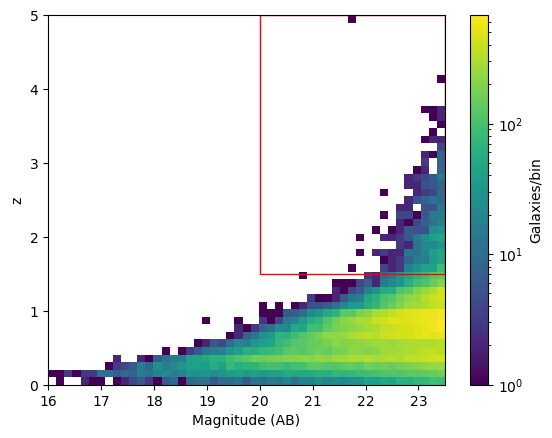

In [7]:
magnitude_range = (20, 23.5)
redshift_range = (1.5, 5)
x, y = catalog.catalog['mag_auto'], catalog.catalog['zphot']
plt.hist2d(x, y, bins=(np.linspace(16, 23.5, 50), np.linspace(0, 5, 50)), norm=matplotlib.colors.LogNorm()) 
plt.colorbar(label='Galaxies/bin')
plt.xlabel('Magnitude (AB)')
plt.ylabel('z')
draw_box(magnitude_range, redshift_range, edgecolor='r')

selection_mask = ((magnitude_range[0] <= x) & (x < magnitude_range[1])
                  & (redshift_range[0] <= y) & (y < redshift_range[1]))

Let's check our selection sample.

In [8]:
print(selection_mask.size)

56062


In [9]:
count = np.count_nonzero(selection_mask)
print(count)

1162


We want to use the Faber Jackson relationship to calculate the Einstein radii, $\theta_E$, of the lensed images.

The Faber Jackson Graph data can be found in the *Data/* folder of this repository.

In [10]:
# get YOUR PATH to the Faber Jackson Graph data
wdir = '/Users/ruby/Documents/Python Scripts/Lenzer/Data/'

# define the cosmology to use
# define the cosmology
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

def give_me_a_straight_line(x,y):
        w, b  = np.polyfit(x,y,deg=1)
        return w,b 

def MakeFaberJackson():
    FJG = pd.read_csv(wdir+'FaberJacksonGraph.csv')

    X = FJG['MB (mag)'].values
    Y = np.log10(FJG['Fourier Velocity 1'].values)

    w, b = give_me_a_straight_line(X,Y)

    return X,Y,w,b
    #y = w * X + b --> calculates velocity dispersion from magnitude

We'll require the magnitude and redshift pairs of example lensing galaxies.

In [11]:
# read the data
csv = pd.read_csv(wdir+'image_catalog2.0train.csv')

Define a function to return the redshift and magnitude of the source and lens galaxy, respectively.

In [12]:
# sampling magnitudes and redshift
def Generate_Lens_System_Mag_Z_2():
    index2 = np.random.randint(0,100000)

    Z3_Data_A = csv[csv['z_source']>3]
    Z3_Data_L = csv[csv['z_source']<3]

    index0 = np.random.randint(0,Z3_Data_A.shape[0])
    index1 = np.random.randint(0,Z3_Data_L.shape[0])
    
    z_source = Z3_Data_A['z_source'].values[index0]
    mag_source = Z3_Data_A['mag_source'].values[index0]
    
    Z_lens_1 = Z3_Data_L['z_source'].values[index1]
    mag_lens_1 = Z3_Data_L['mag_source'].values[index1]

    Z_lens_2 = csv['z_lens'].values[index2]
    mag_lens_2 = csv['mag_lens'].values[index2]
    
    if Z_lens_1 > Z_lens_2: 
        Mid_lens_Z = Z_lens_1
        Mid_lens_Mag = mag_lens_1
        Edge_lens_Z = Z_lens_2
        Edge_lens_Mag = mag_lens_2
    else:
        Mid_lens_Z = Z_lens_2
        Mid_lens_Mag = mag_lens_2
        Edge_lens_Z = Z_lens_1
        Edge_lens_Mag = mag_lens_1
        
    return z_source, mag_source, Mid_lens_Z, Mid_lens_Mag

We'll calculate the Einstein radius, $\theta_E$, from the Faber-Jackson relationship.

In [13]:
# get the velocity dispersion from the Faber Jackson Graph
def Get_Theta_E_From_Velo_Dist(mag_lens, Z_lens, z_source):
    # get the Faber-Jackson Graph
    X, Y, w, b = MakeFaberJackson()
    log_vel_d = w * (mag_lens - cosmo.distmod(Z_lens).value) + b
    vel_disp_iso =10**log_vel_d
    lens_cosmo = LensCosmo(Z_lens, z_source, cosmo=cosmo)
    theta_E_SIS = lens_cosmo.sis_sigma_v2theta_E(vel_disp_iso)
    
    return theta_E_SIS

For detailed proof, see [here](https://lweb.cfa.harvard.edu/~dfabricant/huchra/ay202/lectures/lecture12.pdf), with thanks to Jonathan Pritchard.

We'll get the apparent magnitude of the lensing galaxies. For this, you will require to install [Speclite](https://speclite.readthedocs.io/en/latest/) and [Skypy](https://pypi.org/project/skypy/).

The apparent magnitude for each band is generated using SkyPy. This is used to make blue source galaxies and red lens galaxies. Euclid filter response curves are already supported by Speclite.

In [14]:
import skypy
import speclite
# making red and blue galaxies for Euclid VIS and NISP
def MakeBlueGalaxies_Euclid(redshift, M_lens, cosmology):
    # the following values are taken from the Skypy source code
    alpha0= [2.079, 3.524, 1.917, 1.992, 2.536]
    alpha1= [2.265, 3.862, 1.921, 1.685, 2.480]
    weight= [3.47e+09, 3.31e+06, 2.13e+09, 1.64e+10, 1.01e+09]
    spectral_coefficients = skypy.galaxies.spectrum.dirichlet_coefficients(redshift, alpha0,alpha1,weight)
    filters = 'Euclid-VIS','Euclid-Y','Euclid-H','Euclid-J'
    M = M_lens - cosmo.distmod(redshift).value
    stellar_mass = skypy.galaxies.spectrum.kcorrect.stellar_mass(spectral_coefficients,M,filters)
    app_mag = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes( spectral_coefficients, redshift, filters,cosmology, stellar_mass=stellar_mass)
    
    return app_mag

def MakeRedGalaxies_Euclid(redshift, M_lens, cosmology):
    # the following values are taken from the Skypy source code.
    alpha0= [2.461, 2.358, 2.568, 2.268, 2.402]
    alpha1= [2.410, 2.340, 2.200, 2.540, 2.464]
    weight = [3.84e+09, 1.57e+06, 3.91e+08, 4.66e+10, 3.03e+07]
    spectral_coefficients = skypy.galaxies.spectrum.dirichlet_coefficients(redshift, alpha0,alpha1,weight)
    filters = 'Euclid-VIS','Euclid-Y','Euclid-H','Euclid-J'
    M = M_lens - cosmo.distmod(redshift).value
    stellar_mass = skypy.galaxies.spectrum.kcorrect.stellar_mass(spectral_coefficients,M,filters)
    app_mag = skypy.galaxies.spectrum.kcorrect.apparent_magnitudes( spectral_coefficients, redshift, filters, cosmology, stellar_mass=stellar_mass)
    
    return app_mag

Let's set up the lensing parameters.

Apart from the Einstein radius, $\theta_E$, all other lensing parameters will be randomly selected.

In [15]:
n_images = count * 10

md = dict()

# index in the catalog of the galaxy image to use
md['source_index'] = catalog.sample_indices(n_images, selection_mask)

# rotation (in radians) to give the source image
md['source_rotation'] = 2.0 * np.pi * np.random.rand(n_images)

# Einstein radius (in arcseconds) of the lens
theta_E = []
lens_galaxy_z = []
for i in range(n_images):
    z_source, mag_source, z_lens, mag_lens = Generate_Lens_System_Mag_Z_2()
    lens_gal_mag = MakeRedGalaxies_Euclid(z_lens, mag_lens, cosmo)
    radius = Get_Theta_E_From_Velo_Dist(lens_gal_mag[0], z_lens, z_source)
    theta_E.append(radius)
    lens_galaxy_z.append(z_lens)
md['theta_E'] = theta_E
md['z_lens'] = lens_galaxy_z

# Exponent of the lens' power-law mass distribution
md['gamma'] = 2.0 + 0.1 * np.random.rand(n_images)

# ellipticity components of the lens
md['e1'], md['e2'] = np.random.uniform(-0.05, 0.05, (2, n_images))

# location of the lens (in arcseconds) in the image
md['center_x'], md['center_y'] = 0.2 * np.random.rand(2, n_images)

# External shear components
md['gamma1'], md['gamma2'] = 0.16 * np.random.rand(2, n_images)

md['fileName'] = np.arange(n_images)

# save this to a csv
csvfile = pd.DataFrame(md)
imageDict = csvfile.to_dict('records')
csvfile.head()
# save the csv file here
csvfile.to_csv(wdir+'Lens_Parameters.csv')

After quick inspection, it appears that we have appropriate mass-to-light ratios.

![radii](Data/radii.png)


In [16]:
all_indices = np.unique(csvfile['source_index'])

In [17]:
print(all_indices.size)

1162


Now, we want to produce the lens images and split that into a training set, validation set and test set. 
We'll choose to generate 100 validation and test samples.

In [18]:
# n-split for validation and test
n = 100
index_val = np.random.choice(all_indices.shape[0], n, replace=False)
val_indices = all_indices[index_val]
new_all_indices = np.delete(all_indices, index_val)
index_test = np.random.choice(new_all_indices.shape[0], n, replace=False)
test_indices = new_all_indices[index_test]
train_indices = np.delete(new_all_indices, index_test)

print("Train: {}, Val: {}, Test: {}".format(train_indices.size, val_indices.size, test_indices.size))

Train: 962, Val: 100, Test: 100


Now let's initialise *Lenzer*.

In [19]:
from lenzer import *

lens_class = Lenzer(catalog=catalog, pixel_width=0.08)

Let's simulate!

In [21]:
# create a 'dummy' lens that does not lens at all (if you also want the non-lensed sources)
no_lens = [('SIS', dict(theta_E=0))]

lenses = []
for i in range(n_images):
    source_kwargs = dict(catalog_i=csvfile['source_index'][i],
                        phi=csvfile['source_rotation'][i])
    
    unlensed_img = lens_class.lensed_image(lenses=no_lens, **source_kwargs)
    
    lensed_img = lens_class.lensed_image(lenses=[
        ('SIE', {k: csvfile[k][i] for k in 'theta_E e1 e2 center_x center_y'.split()}),
        ('SHEAR', {k: csvfile[k][i] for k in 'gamma1 gamma2'.split()})], **source_kwargs)
    
    # save to file
    if (csvfile['source_index'][i] in test_indices):
        path = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Test"
    elif (csvfile['source_index'][i] in val_indices):
        path = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Val"  
    else:
        path = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Train"

    # Be aware, these images are now arrays of floats; most image formats are made of integers.
    # Unless you use a float-image format (or just save the numpy array),
    # you will have to commit to some discretisation and normalisation here.
        
    #unlensed_img_name = "{}/Unlensed/{}".format(path, i)
    np.save(path+'/Unlensed/'+str(i), unlensed_img)
    
    #lensed_img_name = "{}/Lensed/{}".format(path, i)
    np.save(path+'/Lensed/'+str(i), lensed_img)
    
    # these images are now just arrays of floats
    lenses.append(lensed_img)

Of course, we'll want to save each set's lens parameters and we'll do this using each *.npy* file's unique source id.

In [22]:
train_file = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Train/train_params.csv"
val_file = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Val/val_params.csv"
test_file = "/Users/ruby/Documents/Python Scripts/Lenzer/Data/Test/test_params.csv"

params_val = csvfile.loc[csvfile['source_index'].isin(val_indices)]
params_val.to_csv(val_file, index=False, header=True)

params_test = csvfile.loc[csvfile['source_index'].isin(test_indices)]
params_test.to_csv(test_file, index=False, header=True)

params_train = csvfile.loc[csvfile['source_index'].isin(train_indices)]
params_train.to_csv(train_file, index=False, header=True)


Let's inspect this.

In [24]:
params_train

,source_index,source_rotation,theta_E,z_lens,gamma,e1,e2,center_x,center_y,gamma1,gamma2,fileName
0,34254,0.491117,0.582825,1.75,2.058862,0.035146,0.032246,0.051321,0.083589,0.058461,0.063701,0
1,42187,2.808935,0.460332,2.46,2.037036,-0.002371,-0.017160,0.101760,0.120685,0.080121,0.100031,1
2,1488,3.035198,0.671616,1.99,2.067653,-0.028972,0.003763,0.198689,0.173727,0.031633,0.031330,2
3,510,1.457934,0.560348,2.33,2.025425,0.035796,-0.021446,0.107390,0.046703,0.051127,0.050278,3
4,7216,0.734691,1.255911,2.33,2.075608,-0.020848,-0.049129,0.009580,0.043717,0.134136,0.080400,4
...,...,...,...,...,...,...,...,...,...,...,...,...
11615,8993,4.915642,0.492061,2.51,2.098605,-0.005456,-0.041409,0.120159,0.057412,0.042396,0.071617,11615
11616,18419,3.769289,0.346501,1.42,2.062075,0.022629,0.030932,0.170678,0.049489,0.158778,0.117433,11616
11617,13989,1.983705,1.792372,2.65,2.026047,-0.045579,0.014031,0.084373,0.185433,0.023526,0.149333,11617
11618,39701,5.095559,0.327283,2.25,2.034351,0.028306,-0.016185,0.129140,0.140381,0.073624,0.055468,11618


We can visualise the lensed and non-lensed images before painting into the cut-outs.

In [29]:
from utils import plot_image

datafile = np.load("/Users/ruby/Documents/Python Scripts/Lenzer/Data/Train/Lensed/0.npy")

In [26]:
print(np.amax(datafile))

0.2543325697670978


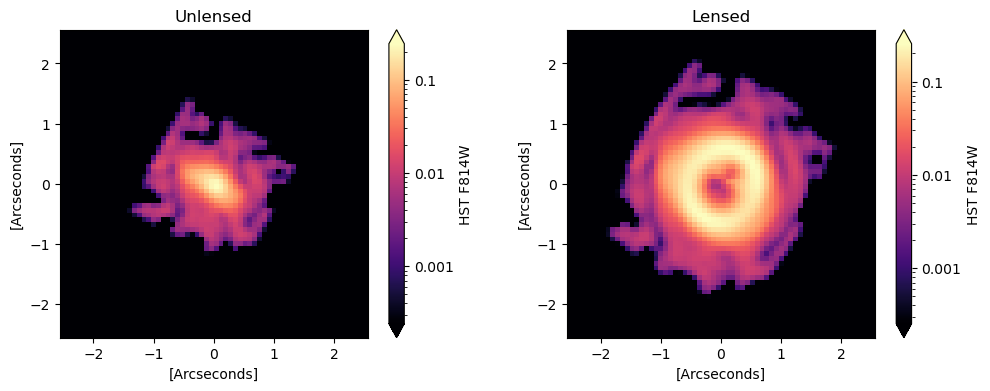

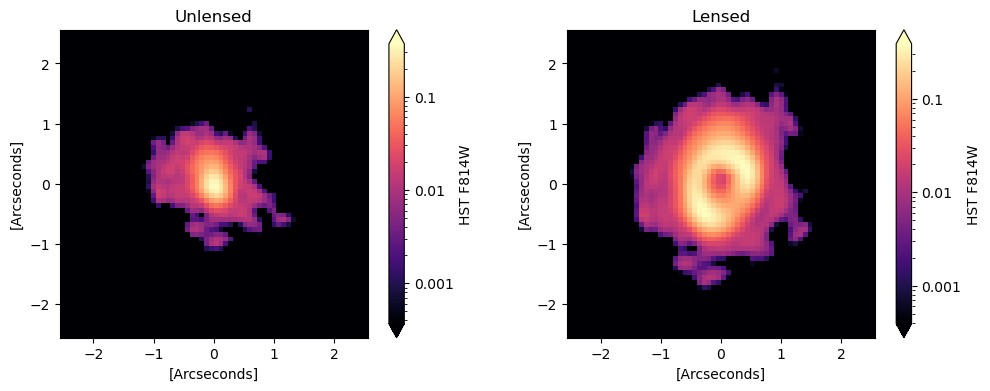

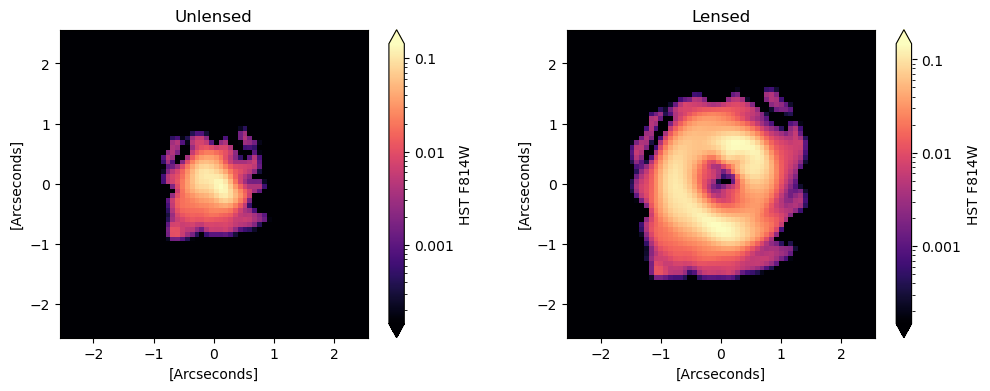

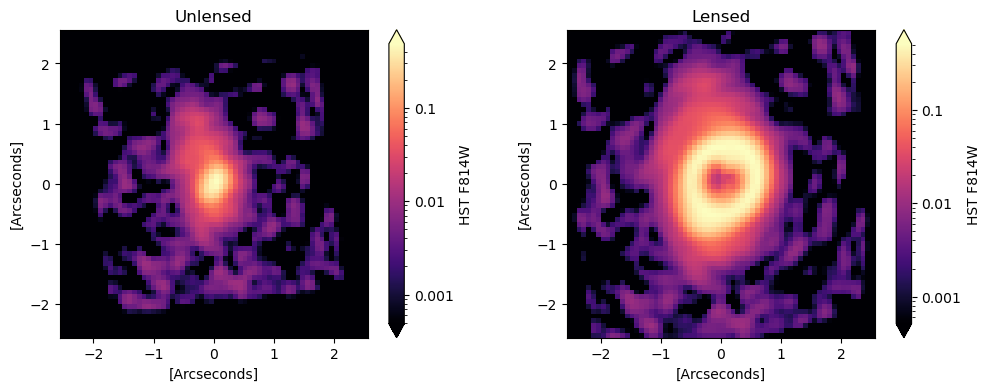

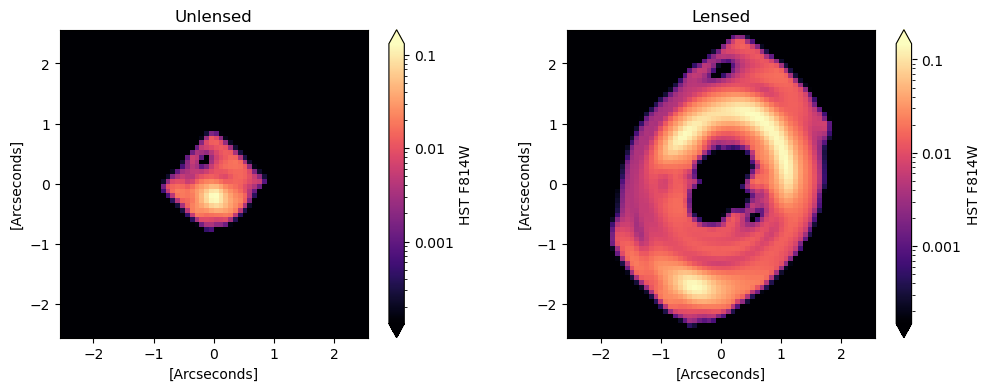

In [30]:
plot = True
pixel_width = 0.08

for i in range(0, 5):
    lensed_img = np.load("/Users/ruby/Documents/Python Scripts/Lenzer/Data/Train/Lensed/"+str(i)+".npy")
    unlensed_img = np.load("/Users/ruby/Documents/Python Scripts/Lenzer/Data/Train/Unlensed/"+str(i)+".npy")
    if plot:
        f, axes = plt.subplots(ncols=2, figsize=(12, 4))
        
        plt.sca(axes[0])
        plot_image(unlensed_img, pixel_width)
        plt.title("Unlensed")
        
        plt.sca(axes[-1])
        plot_image(lensed_img, pixel_width)
        plt.title("Lensed")

### Lens Painting 
Here, we show an example of how to paint lenses into the Euclid ERO cut-outs.
For this, you will need your own set of Euclid cut-outs.

In [31]:
# import required packages to do this
import astropy 
from astropy.io import fits 
from skimage.transform import resize 

Get the path to YOUR cut-outs.

In [32]:
data_path = '/Users/ruby/Documents/Python Scripts/Euclid-cGAN/' 
path_lenses = '/Users/ruby/Documents/Python Scripts/Lenzer/Data/Test/'

Define a function to perform a min-max normalisation.

In [33]:
def Normalise(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

Now, we'll load in the lenses that we simulated for the test set ($100$), we'll normalise them, resize them to $100\times100$ pixels and create a list of lenses to iterate over such that we can add them to individual Euclid cutouts.

In [35]:
lens_data = pd.read_csv(test_file)
dataset = []
lens_imgs = []
for i in range(lens_data.shape[0]):
    try:
        img = np.load(path_lenses+'Lensed/'+lens_data['fileName'][i].astype(str)+'.npy')
        dataset.append(img)
    except:
        # continue
        print(path_lenses+'Lensed/'+lens_data['fileName'][i].astype(str))
    # now we resize and normalise each image in the dataset list
    lens = dataset[i]
    lens_norm = Normalise(lens)
    lens_resize = resize(lens_norm, (100,100))
    lens_imgs.append(lens_resize)

/var/folders/9h/r1jl5z8j0252hq0p27nzdc_40000gp/T/ipykernel_80743/172517669.py:2: RuntimeWarning: invalid value encountered in divide
  return (data - np.min(data))/(np.max(data) - np.min(data))
/Users/ruby/miniconda3/envs/science/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/ruby/miniconda3/envs/science/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


Now, we'll paint these lenses into the individual cut-outs from the Euclid ERO data.

In [45]:
import os 
# paint an individual lens into each individual crop
path_to_crop = data_path+'Crop 8/'
n_cutouts = len(os.listdir(path_to_crop+'VIS/'))
lens = lens_imgs[:(n_cutouts - 200)]
lensed_dataset = []
for i in range(0, 100):
    vis = path_to_crop+'NISP-Y/' 
    nisp_y = path_to_crop+'NISP-J/'
    nisp_h = path_to_crop+'NISP-H/'  

    hdu_vis = fits.open(vis+str(i)+'.fits')
    data_vis = np.array(hdu_vis[0].data) + Normalise(lens[i])
    hdu_y = fits.open(nisp_y+str(i)+'.fits')
    data_y = np.array(hdu_y[0].data) + Normalise(lens[i])
    hdu_h = fits.open(nisp_h+str(i)+'.fits')
    data_h = np.array(hdu_h[0].data) + Normalise(lens[i])

    img = np.dstack((data_h, data_y, data_vis))
    img /= np.max(img)
    lensed_dataset.append(img)

And we are done with our final simulations as follows:

![samples.png](Data/samples.png)